In [25]:
import numpy as np
import pandas as pd
import rebound
from celmech import Andoyer, AndoyerHamiltonian
import dask.dataframe as dd
from celmech import *
from celmech.resonances import resonant_period_ratios
from celmech.andoyer import get_num_fixed_points
from collections import OrderedDict
import random
%matplotlib inline

In [2]:
respath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/data/resonant/'
sapath = 'simulation_archives/runs/sa'

# Whether you pasas the averaged pvars a10 or the unaveraged a10 matters for these small differences in dK:

If you want to set a10 = ps[1].a so that dL1hat = 0, you have to pass it the avaraged a, i.e. pvars.particles[1].a, not sim.particles[1].a. Just need to be consistent.

In [3]:
runstring = '0000000.bin'
snapshot = 0
i1 = 2
i2 = 3
j=12
k=1
sa = rebound.SimulationArchive(respath+sapath+runstring)
sim = sa[snapshot]
pvars = Poincare.from_Simulation(sim) # averaging step only makes sense if not crossing 
avars = Andoyer.from_Poincare(pvars, j=j, k=k, a10=pvars.particles[i1].a, i1=i1, i2=i2)
avars2 = Andoyer.from_Poincare(pvars, j=j, k=k, a10=sim.particles[i1].a, i1=i1, i2=i2)
print('dL1hat (avgd a, sim.a):', (avars.dL1hat, avars2.dL1hat))

dL1hat (avgd a, sim.a): (1.8634724839594607e-20, 3.397225204768493e-06)


/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


# Dependence on location of expansion chosen a10

For the more general case where conserved quantities like dKprime vary, we want to be able to compute them accurately in the generic case. Also want to understand which quantities depend on the expansion location a10.

So we want the transformation to learn the dependence on a1, so don't want to pass a10=a10, but a random number around that. This will shift dKprime as it should...it's a scaling parameter that keeps track of the a10 you used so you can invert. But it should leave the physical quantities intact to leading order, i.e., we're expanding around the resonance in powers of dLhat = $d\Lambda/\Lambda$, and it's the last (quadratic term) that matters, so I think the fractional correction to the quantities we calculate from the next higher term is just $d\Lambda/\Lambda = (a1-a10)/a10$, which depends on how well we choose a10. Can play around with the factor by which we multiply a10 to see this:

In [4]:
fac = 1.0001

pvars = Poincare.from_Simulation(sim) # averaging step only makes sense if not crossing

a10 = pvars.particles[i1].a
avars = Andoyer.from_Poincare(pvars, j=j, k=k, a10=a10, i1=i1, i2=i2)

a10 = pvars.particles[i1].a*fac
avars2 = Andoyer.from_Poincare(pvars, j=j, k=k, a10=a10, i1=i1, i2=i2)

print('dL1hat (unfudged, fudged):', (avars.dL1hat, avars2.dL1hat))
print('Zstar (unfudged, fudged):', (avars.Zstar, avars2.Zstar))
print('Zstar frac error, dL1hat fudged (should be comparable):', np.abs((avars.Zstar-avars2.Zstar)/avars.Zstar), np.abs(avars2.dL1hat))

dL1hat (unfudged, fudged): (1.8634724839594607e-20, -4.999625031255539e-05)
Zstar (unfudged, fudged): (0.02164463201597541, 0.02164410793185729)
Zstar frac error, dL1hat fudged (should be comparable): 2.4213122114233744e-05 4.999625031255539e-05


# Scale Invariance

G has dimensions of $m^{-1}d^3s^{-2}$ or $m^{-1}v^{2}d$. If we change all the quantities in the simulation by factors that keep G the same, we'll get the same dynamics. For example, if we multiply the masses by a factor, multiply the velocities by sqrt(factor) and keep the distances the same, we get the same dynamics (same outputs if we scale to central mass, inner orbital period and inner semimajor axis). You can see this by writing $rdot = v$ and $vdot = -Gm*m/r$ if you solve for how our scaling affects the time (t = d/v so we need to divide times by sqrt(factor)). 

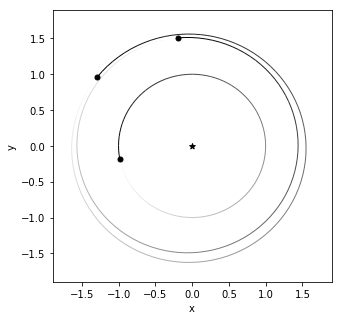

In [56]:
i1 = 2
i2 = 3
j=12
k=1
sa = rebound.SimulationArchive(respath+sapath+runstring)
sim = sa[snapshot]
pvars = Poincare.from_Simulation(sim) # averaging step only makes sense if not crossing
a10 = pvars.particles[i1].a
avars = Andoyer.from_Poincare(pvars, j=j, k=k, a10=a10, i1=i1, i2=i2)
fig = rebound.OrbitPlot(sim)

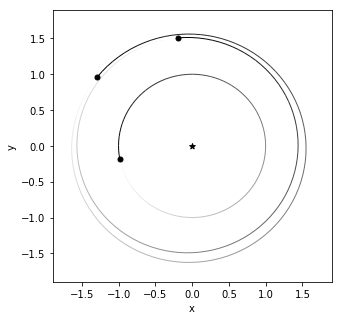

In [57]:
fac = 3.
for p in sim.particles:
    p.m *= fac
    p.vx *= np.sqrt(fac)
    p.vy *= np.sqrt(fac)
    p.vz *= np.sqrt(fac)
    
pvars2 = Poincare.from_Simulation(sim) # averaging step only makes sense if not crossing
a102 = pvars2.particles[i1].a
avars2 = Andoyer.from_Poincare(pvars2, j=j, k=k, a10=a102, i1=i1, i2=i2)
fig = rebound.OrbitPlot(sim)

All our quantities should be invariant to this transformation. I've added a unit test for this. Though some quantities do have scales associated with them, e.g. tlibration or the scaling parameters to bring the Hamiltonian in the celmech notes to the same standard form. These will change. Some digits are lost when subtracting e.g. (a2-a20)/a20, so not quite true to 16 digits

In [58]:
p = avars.params
p2 = avars2.params
print(avars.params['alpha'], avars2.params['alpha'], np.abs((avars.params['alpha'] - avars2.params['alpha'])/avars.params['alpha']))
print(avars.dKprime, avars2.dKprime, np.abs((avars.dKprime - avars2.dKprime)/avars.dKprime))
print(avars.Zstar, avars2.Zstar, np.abs((avars.Zstar - avars2.Zstar)/avars.Zstar))
print(avars.dP, avars2.dP, np.abs((avars.dP - avars2.dP)/avars.dP))
print(avars.theta1, avars2.theta1, np.abs((avars.theta1 - avars2.theta1)/avars.theta1))
print(avars.theta, avars2.theta, np.abs((avars.theta - avars2.theta)/avars.theta))
print(avars.phiZcom, avars2.phiZcom, np.abs((avars.phiZcom - avars2.phiZcom)/avars.phiZcom))

0.9436466248346231 0.9436466248346231 0.0
2.1795937766521922e-06 2.1795937766608883e-06 3.9897635266435915e-12
0.02164463201597541 0.021644632015974746 3.061564490142604e-14
0.000378693512586612 0.0003786935125881243 3.993465295884951e-12
0.13636031773624488 0.136360317736245 8.141833658473918e-16
11.427329291106979 11.427329291106915 5.5961322710964094e-15
-0.15970427383724914 -0.1597042738372575 5.231186404452835e-14


# Rotational Invariance

First test that recreating sim from orbital elements give same result. Does to within $\sim 10^{-12}$

In [8]:
sa = rebound.SimulationArchive(respath+sapath+runstring)
sim = sa[snapshot]

ps = sim.particles
simrot = rebound.Simulation()
simrot.G = sim.G
simrot.add(m=ps[0].m)#, x=ps[0].x, y=ps[0].y, z=ps[0].z, vx=ps[0].vx, vy=ps[0].vy, vz=ps[0].vz)
for p in ps[1:]:
    simrot.add(m=p.m, a=p.a, e=p.e, inc=p.inc, Omega=p.Omega, pomega=p.pomega, l=p.l)
simrot.move_to_com()

print(np.abs((sim.particles[1].vx - simrot.particles[1].vx)/sim.particles[1].vx))

4.093752143765234e-12


# Test rotational invariance

Matches to 1e-12. Added unit test

In [9]:
rot = np.pi/3.

i1 = 2
i2 = 3
j=12
k=1
sa = rebound.SimulationArchive(respath+sapath+runstring)
sim = sa[snapshot]
avars = Andoyer.from_Simulation(sim, j=j, k=k, i1=i1, i2=i2)

ps = sim.particles
simrot = rebound.Simulation()
simrot.G = sim.G
simrot.add(m=ps[0].m)#, x=ps[0].x, y=ps[0].y, z=ps[0].z, vx=ps[0].vx, vy=ps[0].vy, vz=ps[0].vz)
for p in ps[1:]:
    simrot.add(m=p.m, a=p.a, e=p.e, inc=p.inc, Omega=p.Omega+rot, pomega=p.pomega+rot, l=p.l+rot)
simrot.move_to_com()

avars2 = Andoyer.from_Simulation(simrot, j=j, k=k, i1=i1, i2=i2)

p = avars.params
p2 = avars2.params
print(avars.params['alpha'], avars2.params['alpha'], np.abs((avars.params['alpha'] - avars2.params['alpha'])/avars.params['alpha']))
print(avars.dKprime, avars2.dKprime, np.abs((avars.dKprime - avars2.dKprime)/avars.dKprime))
print(avars.Zstar, avars2.Zstar, np.abs((avars.Zstar - avars2.Zstar)/avars.Zstar))
print(avars.dP, avars2.dP, np.abs((avars.dP - avars2.dP)/avars.dP))

0.9436466248346231 0.9436466248346231 0.0
2.1795937766521922e-06 2.1795937766564096e-06 1.9349371839632243e-12
0.02164463201597541 0.021644632015975163 1.138068475393324e-14
0.000378693512586612 0.00037869351258734246 1.928950957524096e-12


In [10]:
rot = np.pi/3.
j=4
k=1
i1=1
i2=2
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-5, P=1.5, e=0.02, pomega=0.3, l=0.4)
sim.add(m=1.e-7, P=2., e=0.01, pomega=2.3, l=4.4)
sim.add(m=1.e-3, a=1., e=0.2, pomega=0.3, l=0.4)
sim.move_to_com()
avars = Andoyer.from_Simulation(sim, j=j, k=k, i1=i1, i2=i2)

ps = sim.particles
simrot = rebound.Simulation()
simrot.G = sim.G
simrot.add(m=ps[0].m)#, x=ps[0].x, y=ps[0].y, z=ps[0].z, vx=ps[0].vx, vy=ps[0].vy, vz=ps[0].vz)
for p in ps[1:]:
    simrot.add(m=p.m, a=p.a, e=p.e, inc=p.inc, Omega=p.Omega+rot, pomega=p.pomega+rot, l=p.l+rot)
simrot.move_to_com()

avars2 = Andoyer.from_Simulation(simrot, j=j, k=k, i1=i1, i2=i2)

p = avars.params
p2 = avars2.params
print(avars.params['alpha'], avars2.params['alpha'], np.abs((avars.params['alpha'] - avars2.params['alpha'])/avars.params['alpha']))
print(avars.dKprime, avars2.dKprime, np.abs((avars.dKprime - avars2.dKprime)/avars.dKprime))
print(avars.Zstar, avars2.Zstar, np.abs((avars.Zstar - avars2.Zstar)/avars.Zstar))
print(avars.dP, avars2.dP, np.abs((avars.dP - avars2.dP)/avars.dP))

0.8254845363046502 0.8254845363046502 0.0
9.403678854644642e-07 9.403678854644641e-07 1.1259329464924463e-16
0.01765871825888089 0.01765871825888094 2.9470827676369715e-15
0.00045942979437881676 0.00045942979437881676 0.0


The angles are not all rotationally invariant, only the one that matters for the dynamics $\phi$ because it obeys the d'Alembert relation. Of the others, phiZcom is a direction in space, so it gets rotated along with the coordinate axes.

$\theta = j\lambda_2-(j-k)\lambda_1$ rotates by k*rot
$\theta_1 = (\Lambda_{10}\lambda_1 + \Lambda_{20}\lambda_2)/K_0$ rotates by $rot*(\Lambda_{10} + \Lambda_{20})/K_0$

Because shifts by $2\pi$ do not wrap around because of the factors of $\Lambda_{10}$, I added a np.mod(l, 2\pi) on the mean longitudes in from_Poincare so that values of longitudes varying by 2pi give the samae values for these two angles. All possibilities give back the right longitudes to within a factor of $2\pi$ when we convert back, but we want the transformation to be deterministic.

In [11]:
theta1rot = avars.theta1 + (p['m1']*p['sLambda10'] + p['m2']*p['sLambda20'])/p['K0']*rot
print(theta1rot, avars2.theta1, np.abs((theta1rot - avars2.theta1)/avars.theta1))
print(avars.theta+k*rot, avars2.theta, np.abs((avars.theta+k*rot - avars2.theta)/avars.theta))
print(avars.phiZcom+rot, avars2.phiZcom, np.abs((avars.phiZcom+rot - avars2.phiZcom)/avars.phiZcom))

0.3737031173837361 0.37370311738374734 1.0084834562403239e-13
17.447197378550175 17.44719737855004 8.23189763509919e-15
1.351531230231885 1.3515312302318885 1.1673744720145042e-14


# There's a first transformation I forgot to mention to 'averaged variables' 

It essentially tries to take away the effects of conjunctions where an inner planet overtakes an outer one, where the orbital elements will jump up and then back down. This is not really necessary if you start far from a conjunction, but if you're trying to get resonant variables at a snapshot that's undergoing a conjunction, then the orbital elements you'd use would not be representative of the whole orbit. These are small corrections that look a lot like forces and I think make sense in a graphnet. For each pair of planets you calculate equal and opposite corrections on each particle's semimajor axis, which is weighted by the other's mass. 

# Use this first simulation as a testing example

In [12]:
runstring = '0000000.bin'
snapshot = 0
sa = rebound.SimulationArchive(respath+sapath+runstring)
sim = sa[snapshot]
poinc = Poincare.from_Simulation(sim)

In [13]:
print('P2/P1', sim.particles[2].P/sim.particles[1].P)
print('P3/P2', sim.particles[3].P/sim.particles[2].P)

P2/P1 1.8445744838304716
P3/P2 1.0916975177402766


In [14]:
i1 = 2
i2 = 3

The outer two planets are close to 12:11 (1.0909 period ratio) resonance, so set the indices to the outer two:

In [15]:
pvars = Poincare.from_Simulation(sim) # averaging step only makes sense if not crossing

# Resonance Strengths

This function calculates resonance strengths for a j:j-k resonance given masses (m), mean motions = 2pi/orbital period (n), eccentricities (e) and longitude of pericenter (pomega) for each body

In [16]:
def calc_res_strength(j, k, m1, m2, n1, n2, e1, e2, pomega1, pomega2):
    Z = np.sqrt((e1*np.cos(pomega1) - e2*np.cos(pomega2))**2 + (e1*np.sin(pomega1) - e2*np.sin(pomega2))**2)
    #print(Z)
    return np.abs(np.sqrt(m1+m2)*Z**(k/2.)/(j*n2 - (j-k)*n1))

# Finding the Strong Resonances

This function in celmech takes a min period ratio, max period ratio and a maximum order resonance to consider (we want to set this to two). It then returns a list of all the resonances that lie in that period range. The period ratio should be less than one, i.e. Period(inner)/P(outer). You'd look through all the pairs (or adjacent pairs), but here we've already figured out which particles indices are closest to resonance

In [17]:
delta = 0.03
Pratio = sim.particles[i1].P/sim.particles[i2].P
minperiodratio = max(Pratio-delta, 0.)
maxperiodratio = min(Pratio+delta, 0.999) # too many resonances close to 1
res = resonant_period_ratios(minperiodratio,maxperiodratio, order=2)

In [18]:
res

array([[ 8,  9],
       [17, 19],
       [ 9, 10],
       [19, 21],
       [10, 11],
       [21, 23],
       [11, 12],
       [23, 25],
       [12, 13],
       [25, 27],
       [13, 14],
       [27, 29],
       [14, 15],
       [29, 31],
       [15, 16],
       [31, 33],
       [16, 17],
       [33, 35],
       [17, 18],
       [35, 37]])

In [19]:
ps = poinc.particles
res = resonant_period_ratios(Pratio-delta,Pratio+delta, order=2)
strengths = np.zeros((len(res), 3))
for i, (a, b) in enumerate(res):
    j = b
    k = b-a
    strengths[i] = [j, k, calc_res_strength(j, k, ps[i1].m, ps[i2].m, ps[i1].n, ps[i2].n, ps[i1].e, ps[i2].e, ps[i1].pomega, ps[i2].pomega)]

sortedstrengths = strengths[strengths[:,2].argsort()][::-1]
    
for res in sortedstrengths:
    print(int(res[0]), int(res[1]), res[2])

12 1 0.04824427381301188
11 1 0.0023070135609413005
13 1 0.0021056332109779573
10 1 0.0011265707951570027
14 1 0.0010763043905751453
9 1 0.0007452463510067455
15 1 0.0007229121907158289
16 1 0.0005442228582438629
17 1 0.00043636277066132716
23 2 0.0004265723762116975
18 1 0.0003641846421540085
25 2 0.000355215345756078
21 2 0.00013326705829331707
27 2 0.00012539726720066434
19 2 7.896903347674869e-05
29 2 7.613758765659086e-05
31 2 5.466398904442725e-05
33 2 4.263839439538971e-05
35 2 3.494975669386216e-05
37 2 2.9610359439953797e-05


# Max strength is for the j=12, k=1 = 12:11 (j:j-k) resonance as expected

In [20]:
strongres = sortedstrengths[0]
print(strongres)

[12.          1.          0.04824427]


# Compare the simplified resonance model evolution (orange) to the Nbody one in resonance variables

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

j = int(strongres[0])
k = int(strongres[1])

andvars = Andoyer.from_Simulation(sim=sim, j=j, k=k, i1=i1, i2=i2)
H = AndoyerHamiltonian(andvars)
tmax=100*andvars.params['tau']
Nout = 1000
times = np.linspace(0, tmax, Nout)

Z, phi = np.zeros(Nout), np.zeros(Nout)
NZ, Nphi = np.zeros(Nout), np.zeros(Nout)

for i, time in enumerate(times):
    H.integrate(time)
    sim.integrate(time)
    Z[i] = H.state.Z
    phi[i] = H.state.phi
    NZ[i] = Andoyer.from_Simulation(sim=sim, j=j, k=k, i1=i1, i2=i2).Z
    Nphi[i] = Andoyer.from_Simulation(sim=sim, j=j, k=k, i1=i1, i2=i2).phi

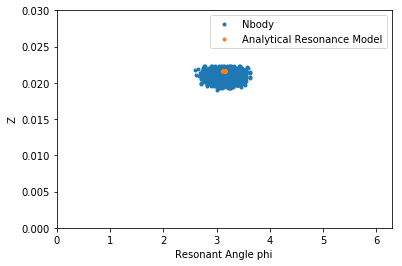

In [22]:
fig, ax = plt.subplots()
ax.plot(Nphi, NZ, '.', label='Nbody')
ax.plot(phi, Z, '.', label='Analytical Resonance Model')
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 0.03])
ax.set_xlabel('Resonant Angle phi')
ax.set_ylabel('Z')
ax.legend()

In [86]:
def initrow(sim, runstring, snapshot):
    row = OrderedDict()
    row['runstring'] = runstring
    row['snapshot'] = snapshot
    ps = sim.particles
    row['crossing'] = 1 if (ps[1].a/ps[2].a >= 1. or ps[2].a/ps[3].a >= 1.) else 0
    return row

def transform_to_res(sim, runstring, snapshot, j, k, i1, i2):
    row = initrow(sim, runstring, snapshot)
    if row['crossing'] == True:
        return set_row_nan(row)
    
    pvars = Poincare.from_Simulation(sim) # averaging step only makes sense if not crossing
    a10 = pvars.particles[i1].a*random.uniform(0.99, 1.01) # don't want to pass exactly a1 so that it learns the a1 dependence (see above)
    ps = pvars.particles
    avars = Andoyer.from_Poincare(pvars, j=j, k=k, a10=a10, i1=i1, i2=i2)
    row['a10'] = a10
    row['i1'] = i1
    row['i2'] = i2
    row['j'] = j
    row['k'] = k
    row['m1'] = ps[i1].m
    row['m2'] = ps[i2].m
    row['M1'] = ps[i1].M
    row['M2'] = ps[i2].M
    row['n1'] = ps[i1].n
    row['n2'] = ps[i2].n
    row['a1cosl1'] = ps[i1].a*np.cos(ps[i1].l)
    row['a1sinl1'] = ps[i1].a*np.sin(ps[i1].l)
    row['a2cosl2'] = ps[i2].a*np.cos(ps[i2].l)
    row['a2sinl2'] = ps[i2].a*np.sin(ps[i2].l)
    row['k1'] = ps[i1].e*np.cos(ps[i1].pomega)
    row['h1'] = ps[i1].e*np.sin(ps[i1].pomega)
    row['k2'] = ps[i2].e*np.cos(ps[i2].pomega)
    row['h2'] = ps[i2].e*np.sin(ps[i2].pomega)
    
    row['Zcosphi'] = avars.Z*np.cos(avars.phi)
    row['Zsinphi'] = avars.Z*np.sin(avars.phi)
    row['Zcomcosphicom'] = avars.Zcom*np.cos(avars.phiZcom)
    row['Zcomsinphicom'] = avars.Zcom*np.sin(avars.phiZcom)
    row['Phiprime'] = avars.Phiprime
    row['dKprime'] = avars.dKprime
    row['costheta'] = np.cos(avars.theta)
    row['sintheta'] = np.sin(avars.theta)
    row['costheta1'] = np.cos(avars.theta1)
    row['sintheta1'] = np.sin(avars.theta1)
    row['alpha'] = ps[i1].a/ps[i2].a
    row['res_strength'] = np.abs(np.sqrt(ps[i1].m/row['M1'] + ps[i2].m/row['M2'])*avars.Z**(k/2.)*ps[i1].n/(j*ps[i2].n - (j-k)*ps[i1].n))
    row['Zstar'] = avars.Zstar
    row['Zstarnonres'] = avars.Zstar_nonres
    row['Zstarunstable'] = avars.Zstar_unstable
    row['Zsep_inner'] = avars.Zsep_inner
    row['Zsep_outer'] = avars.Zsep_outer
    
    return row

def set_row_nan(row):
    row['a10'] = np.nan
    row['i1'] = 0
    row['i2'] = 0
    row['j'] = 0
    row['k'] = 0
    row['m1'] = np.nan
    row['m2'] = np.nan
    row['M1'] = np.nan
    row['M2'] = np.nan
    row['n1'] = np.nan
    row['n2'] = np.nan
    row['a1cosl1'] = np.nan
    row['a1sinl1'] = np.nan
    row['a2cosl2'] = np.nan
    row['a2sinl2'] = np.nan
    row['k1'] = np.nan
    row['h1'] = np.nan
    row['k2'] = np.nan
    row['h2'] = np.nan
    
    row['Zcosphi'] = np.nan
    row['Zsinphi'] = np.nan
    row['Zcomcosphicom'] = np.nan
    row['Zcomsinphicom'] = np.nan
    row['Phiprime'] = np.nan
    row['dKprime'] = np.nan
    row['costheta'] = np.nan
    row['sintheta'] = np.nan
    row['costheta1'] = np.nan
    row['sintheta1'] = np.nan
    row['alpha'] = np.nan
    row['res_strength'] = np.nan
    row['Zstar'] = np.nan
    row['Zstarnonres'] = np.nan
    row['Zstarunstable'] = np.nan
    row['Zsep_inner'] = np.nan
    row['Zsep_outer'] = np.nan
    
    return row

# Test function

Zcosphi = -0.02 and Zsinphi = 0 as expected from above

In [87]:
random.seed(0)
sa = rebound.SimulationArchive(respath+sapath+runstring)
sim = sa[0]
t = transform_to_res(sim, runstring, 0, 12, 1, 2, 3)
t

OrderedDict([('runstring', '0000000.bin'),
             ('snapshot', 0),
             ('crossing', 0),
             ('a10', 1.5144336012448354),
             ('i1', 2),
             ('i2', 3),
             ('j', 12),
             ('k', 1),
             ('m1', 1.24440162459276e-05),
             ('m2', 2.531701779802877e-07),
             ('M1', 1.000008459201472),
             ('M2', 0.9999962682460426),
             ('n1', 3.406264592525528),
             ('n2', 3.1213255608381356),
             ('a1cosl1', -0.06910187220909886),
             ('a1sinl1', 1.5024846718853209),
             ('a2cosl2', -1.2118409747143202),
             ('a2sinl2', 1.0359132524808026),
             ('k1', 0.04136978390960896),
             ('h1', -0.00716342671032666),
             ('k2', 0.027415521869871017),
             ('h2', 0.02051528093765677),
             ('Zcosphi', -0.021609128511756684),
             ('Zsinphi', -0.0002819746685027645),
             ('Zcomcosphicom', 0.04106824537813564),
  

# Test that we can take the inputs and get the outputs

In [90]:
from celmech.poincare import PoincareParticle

p1 = PoincareParticle(m=t['m1'], M=t['M1'], l=np.arctan2(t['a1sinl1'], t['a1cosl1']), gamma=-np.arctan2(t['h1'], t['k1']), a=np.sqrt(t['a1cosl1']**2 + t['a1sinl1']**2), e=np.sqrt(t['h1']**2 + t['k1']**2))
p2 = PoincareParticle(m=t['m2'], M=t['M2'], l=np.arctan2(t['a2sinl2'], t['a2cosl2']), gamma=-np.arctan2(t['h2'], t['k2']), a=np.sqrt(t['a2cosl2']**2 + t['a2sinl2']**2), e=np.sqrt(t['h2']**2 + t['k2']**2))
pvars = Poincare(1., [p1, p2])
a = Andoyer.from_Poincare(pvars, j=t['j'], k=t['k'], a10=t['a10'])
print('Recalculated Returned from func Frac. Error')
print(a.Z*np.cos(a.phi), t['Zcosphi'], np.abs((a.Z*np.cos(a.phi)-t['Zcosphi'])/t['Zcosphi']))
print(a.Z*np.sin(a.phi), t['Zsinphi'], np.abs((a.Z*np.sin(a.phi)-t['Zsinphi'])/t['Zsinphi']))
print(a.Zcom*np.cos(a.phiZcom), t['Zcomcosphicom'], np.abs((a.Zcom*np.cos(a.phiZcom)-t['Zcomcosphicom'])/t['Zcomcosphicom']))
print(a.Zcom*np.sin(a.phiZcom), t['Zcomsinphicom'], np.abs((a.Zcom*np.sin(a.phiZcom)-t['Zcomsinphicom'])/t['Zcomsinphicom']))
print(np.cos(a.theta), t['costheta'], np.abs((np.cos(a.theta)-t['costheta'])/t['costheta']))
print(np.sin(a.theta), t['sintheta'], np.abs((np.sin(a.theta)-t['sintheta'])/t['sintheta']))
print(np.cos(a.theta1), t['costheta1'], np.abs((np.cos(a.theta1)-t['costheta1'])/t['costheta1']))
print(np.sin(a.theta1), t['sintheta1'], np.abs((np.sin(a.theta1)-t['sintheta1'])/t['sintheta1']))
alpha = np.sqrt((t['a1sinl1']**2 + t['a1cosl1']**2)/(t['a2sinl2']**2 + t['a2cosl2']**2))
print(alpha, t['alpha'], np.abs((alpha - t['alpha'])/t['alpha']))
print(a.Phiprime, t['Phiprime'], np.abs((a.Phiprime - t['Phiprime'])/t['Phiprime']))
print(a.Zstar, t['Zstar'], np.abs((a.Zstar - t['Zstar'])/t['Zstar']))
print(a.Zstar_nonres, t['Zstarnonres'], np.abs((a.Zstar_nonres - t['Zstarnonres'])/t['Zstarnonres']))
print(a.Zstar_unstable, t['Zstarunstable'], np.abs((a.Zstar_unstable - t['Zstarunstable'])/t['Zstarunstable']))
print(a.Zsep_inner, t['Zsep_inner'], np.abs((a.Zsep_inner - t['Zsep_inner'])/t['Zsep_inner']))
print(a.Zsep_outer, t['Zsep_outer'], np.abs((a.Zsep_outer - t['Zsep_outer'])/t['Zsep_outer']))
resstrength = np.abs(np.sqrt(t['m1']/t['M1'] + t['m2']/t['M2'])*np.sqrt((t['Zcosphi']**2 + t['Zsinphi']**2))**(t['k']/2.)*t['n1']/(t['j']*t['n2'] - (t['j']-t['k'])*t['n1']))
print(resstrength, t['res_strength'], np.abs((resstrength - t['res_strength'])/t['res_strength']))

Recalculated Returned from func Frac. Error
-0.021609128511756975 -0.021609128511756684 1.3486594047767635e-14
-0.0002819746685013094 -0.0002819746685027645 5.1602278080873275e-12
0.04106824537813676 0.04106824537813564 2.737153248410832e-14
-0.006615110637094018 -0.006615110637093807 3.186173503271571e-14
0.41846539773251296 0.41846539773251296 0.0
-0.9082327404914281 -0.9082327404914281 0.0
0.9907173288601742 0.9907173288601742 0.0
0.13593812672006864 0.13593812672006864 0.0
0.9434282804326471 0.9434282804326471 0.0
6.7460629889418255 6.746062988941735 1.3429195511206518e-14
0.021608685074271234 0.0216086850742711 6.261761447358923e-15
0.00046983151630430674 0.00046983151630430365 6.5767750445722564e-15
0.021138853557966932 0.021138853557966786 6.8933147950747894e-15
0.016632759623351916 0.016632759623351732 1.1055332525540765e-14
0.025644947492581945 0.025644947492581838 4.193919895592425e-15
0.1372137344743353 0.1372137344743353 0.0


# runres takes a simulation and pair of particles i1 and i2 and returns list of rows for each resonance found by resonant_period_ratios routine, with input orbital elements and output resonance variables

In [91]:
def runres(sim, runstring, snapshot, i1, i2, maxres):
    try:
        pvars = Poincare.from_Simulation(sim)
    except: # at least one particle on a parabolic or hyperbolic orbit
        return []
    ps = pvars.particles
    delta = 0.03
    Pratio = sim.particles[i1].P/sim.particles[i2].P
    minperiodratio = max(Pratio-delta, 0.)
    maxperiodratio = min(Pratio+delta, 0.999) # too many resonances close to 1
    res = resonant_period_ratios(minperiodratio,maxperiodratio, order=2)
    strengths = np.zeros((len(res), 3))
    for i, (a, b) in enumerate(res):
        j = b
        k = b-a
        strengths[i] = [j, k, calc_res_strength(j, k, ps[i1].m, ps[i2].m, ps[i1].n, ps[i2].n, ps[i1].e, ps[i2].e, ps[i1].pomega, ps[i2].pomega)]

    sortedstrengths = strengths[strengths[:,2].argsort()][::-1]
    
    result = []
    for i, res in enumerate(sortedstrengths):
        if i >= maxres:
            break
        j=int(res[0])
        k=int(res[1])
        #print(snapshot, j, k, i1, i2)
        result.append(transform_to_res(sim, runstring, snapshot, j, k, i1, i2))
        
    return result

# Takes a row in the dataframe of runstrings, loads the appropriate simulationarchive returns a dataframe of resonance transformation examples for all the nearby resonances for every adjacent pair of planets, for each snapshot in the simulationarchive. Takes a max number of snapshots to output for each simulationarchive and max number of resonances to output (orders them from strongest to weakest) for each snapshot

In [92]:
def populate(row, maxsnapshots=10, maxres=10):
    runstring = row['runstring']
    print(runstring)
    sa = rebound.SimulationArchive(respath+sapath+runstring)
    # get a list of examples for all different nearby resonances with runres, for each combination of a) snapshots in the archive and b) pairs of adjacent particles
    maxsnapshots = min(maxsnapshots, len(sa))
    combinations = [runres(sa[snapshot], runstring, snapshot, i1, i1+1, maxres) for snapshot in range(maxsnapshots) for i1 in range(1,3)]
    # flatten the list of resonances for each combination into a single list of examples
    rows = [resonance for case in combinations for resonance in case]
    return pd.DataFrame(data=rows)

# Do 3 res per snapshot, and 10 snapshots per archive. Not all simulationarchives will have the max of each, so this is an upper limit. 

In [93]:
maxres = 3
maxsnapshots = 10
df = pd.read_csv(respath+'resonant.csv', index_col=0)

In [103]:
%%time
random.seed(0)
data = pd.concat([populate(row, maxsnapshots, maxres) for _, row in df.iterrows()])

0000000.bin
0000001.bin
0000002.bin
0000003.bin
0000004.bin
0000005.bin
0000006.bin
0000007.bin
0000008.bin
0000009.bin
0000010.bin
0000011.bin
0000012.bin
0000013.bin
0000014.bin
0000015.bin
0000016.bin
0000017.bin
0000018.bin
0000019.bin
0000020.bin
0000021.bin
0000022.bin
0000023.bin
0000024.bin
0000025.bin
0000026.bin
0000027.bin
0000028.bin
0000029.bin
0000030.bin
0000031.bin
0000032.bin
0000033.bin
0000034.bin
0000035.bin
0000036.bin
0000037.bin
0000038.bin
0000039.bin
0000040.bin
0000041.bin
0000042.bin
0000043.bin
0000044.bin
0000045.bin
0000046.bin
0000047.bin
0000048.bin
0000049.bin
0000050.bin
0000051.bin
0000052.bin
0000053.bin
0000054.bin
0000055.bin
0000056.bin
0000057.bin
0000058.bin
0000059.bin
0000060.bin
0000061.bin
0000062.bin
0000063.bin
0000064.bin
0000065.bin
0000066.bin
0000067.bin
0000068.bin
0000069.bin
0000070.bin
0000071.bin
0000072.bin
0000073.bin
0000074.bin
0000075.bin
0000076.bin
0000077.bin
0000078.bin
0000079.bin
0000080.bin
0000081.bin
0000082.bin
0000

0000686.bin
0000687.bin
0000688.bin
0000689.bin
0000690.bin
0000691.bin
0000692.bin
0000693.bin
0000694.bin
0000695.bin
0000696.bin
0000697.bin
0000698.bin
0000699.bin
0000700.bin
0000701.bin
0000702.bin
0000703.bin
0000704.bin
0000705.bin
0000706.bin
0000707.bin
0000708.bin
0000709.bin
0000710.bin
0000711.bin
0000712.bin
0000713.bin
0000714.bin
0000715.bin
0000716.bin
0000717.bin
0000718.bin
0000719.bin
0000720.bin
0000721.bin
0000722.bin
0000723.bin
0000724.bin
0000725.bin
0000726.bin
0000727.bin
0000728.bin
0000729.bin
0000730.bin
0000731.bin
0000732.bin
0000733.bin
0000734.bin
0000735.bin
0000736.bin
0000737.bin
0000738.bin
0000739.bin
0000740.bin
0000741.bin
0000742.bin
0000743.bin
0000744.bin
0000745.bin
0000746.bin
0000747.bin
0000748.bin
0000749.bin
0000750.bin
0000751.bin
0000752.bin
0000753.bin
0000754.bin
0000755.bin
0000756.bin
0000757.bin
0000758.bin
0000759.bin
0000760.bin
0000761.bin
0000762.bin
0000763.bin
0000764.bin
0000765.bin
0000766.bin
0000767.bin
0000768.bin
0000

0001369.bin
0001370.bin
0001371.bin
0001372.bin
0001373.bin
0001374.bin
0001375.bin
0001376.bin
0001377.bin
0001378.bin
0001379.bin
0001380.bin
0001381.bin
0001382.bin
0001383.bin
0001384.bin
0001385.bin
0001386.bin
0001387.bin
0001388.bin
0001389.bin
0001390.bin
0001391.bin
0001392.bin
0001393.bin
0001394.bin
0001395.bin
0001396.bin
0001397.bin
0001398.bin
0001399.bin
0001400.bin
0001401.bin
0001402.bin
0001403.bin
0001404.bin
0001405.bin
0001406.bin
0001407.bin
0001408.bin
0001409.bin
0001410.bin
0001411.bin
0001412.bin
0001413.bin
0001414.bin
0001415.bin
0001416.bin
0001417.bin
0001418.bin
0001419.bin
0001420.bin
0001421.bin
0001422.bin
0001423.bin
0001424.bin
0001425.bin
0001426.bin
0001427.bin
0001428.bin
0001429.bin
0001430.bin
0001431.bin
0001432.bin
0001433.bin
0001434.bin
0001435.bin
0001436.bin
0001437.bin
0001438.bin
0001439.bin
0001440.bin
0001441.bin
0001442.bin
0001443.bin
0001444.bin
0001445.bin
0001446.bin
0001447.bin
0001448.bin
0001449.bin
0001450.bin
0001451.bin
0001

0002055.bin
0002056.bin
0002057.bin
0002059.bin
0002060.bin
0002061.bin
0002062.bin
0002063.bin
0002064.bin
0002065.bin
0002066.bin
0002067.bin
0002068.bin
0002069.bin
0002070.bin
0002071.bin
0002072.bin
0002073.bin
0002074.bin
0002075.bin
0002076.bin
0002077.bin
0002078.bin
0002079.bin
0002080.bin
0002081.bin
0002082.bin
0002083.bin
0002084.bin
0002085.bin
0002086.bin
0002087.bin
0002088.bin
0002089.bin
0002090.bin
0002091.bin
0002092.bin
0002093.bin
0002094.bin
0002095.bin
0002096.bin
0002097.bin
0002098.bin
0002099.bin
0002100.bin
0002101.bin
0002102.bin
0002103.bin
0002104.bin
0002105.bin
0002106.bin
0002107.bin
0002108.bin
0002109.bin
0002110.bin
0002111.bin
0002112.bin
0002113.bin
0002114.bin
0002115.bin
0002116.bin
0002117.bin
0002118.bin
0002119.bin
0002120.bin
0002121.bin
0002122.bin
0002123.bin
0002124.bin
0002125.bin
0002126.bin
0002127.bin
0002128.bin
0002129.bin
0002130.bin
0002131.bin
0002132.bin
0002133.bin
0002134.bin
0002135.bin
0002136.bin
0002137.bin
0002138.bin
0002

0002739.bin
0002740.bin
0002741.bin
0002742.bin
0002743.bin
0002744.bin
0002745.bin
0002746.bin
0002747.bin
0002748.bin
0002749.bin
0002750.bin
0002751.bin
0002752.bin
0002753.bin
0002754.bin
0002755.bin
0002756.bin
0002757.bin
0002758.bin
0002759.bin
0002760.bin
0002761.bin
0002762.bin
0002763.bin
0002764.bin
0002765.bin
0002766.bin
0002767.bin
0002768.bin
0002769.bin
0002770.bin
0002771.bin
0002772.bin
0002773.bin
0002774.bin
0002775.bin
0002776.bin
0002777.bin
0002778.bin
0002779.bin
0002780.bin
0002781.bin
0002782.bin
0002783.bin
0002784.bin
0002785.bin
0002786.bin
0002787.bin
0002788.bin
0002789.bin
0002790.bin
0002791.bin
0002792.bin
0002793.bin
0002794.bin
0002795.bin
0002796.bin
0002797.bin
0002798.bin
0002799.bin
0002800.bin
0002801.bin
0002802.bin
0002803.bin
0002804.bin
0002805.bin
0002806.bin
0002807.bin
0002808.bin
0002809.bin
0002810.bin
0002811.bin
0002812.bin
0002813.bin
0002814.bin
0002815.bin
0002816.bin
0002817.bin
0002818.bin
0002819.bin
0002820.bin
0002821.bin
0002

0003424.bin
0003425.bin
0003426.bin
0003427.bin
0003428.bin
0003429.bin
0003430.bin
0003431.bin
0003432.bin
0003433.bin
0003434.bin
0003435.bin
0003436.bin
0003437.bin
0003438.bin
0003439.bin
0003440.bin
0003441.bin
0003442.bin
0003443.bin
0003444.bin
0003445.bin
0003446.bin
0003447.bin
0003448.bin
0003449.bin
0003450.bin
0003451.bin
0003452.bin
0003453.bin
0003454.bin
0003455.bin
0003456.bin
0003457.bin
0003458.bin
0003459.bin
0003460.bin
0003461.bin
0003462.bin
0003463.bin
0003464.bin
0003465.bin
0003466.bin
0003467.bin
0003468.bin
0003469.bin
0003470.bin
0003471.bin
0003472.bin
0003473.bin
0003474.bin
0003475.bin
0003476.bin
0003477.bin
0003478.bin
0003479.bin
0003480.bin
0003481.bin
0003482.bin
0003483.bin
0003484.bin
0003485.bin
0003486.bin
0003487.bin
0003488.bin
0003489.bin
0003490.bin
0003491.bin
0003492.bin
0003493.bin
0003494.bin
0003495.bin
0003496.bin
0003497.bin
0003498.bin
0003499.bin
0003500.bin
0003501.bin
0003502.bin
0003503.bin
0003504.bin
0003505.bin
0003506.bin
0003

0004107.bin
0004108.bin
0004109.bin
0004110.bin
0004111.bin
0004112.bin
0004113.bin
0004114.bin
0004115.bin
0004116.bin
0004117.bin
0004118.bin
0004119.bin
0004120.bin
0004121.bin
0004122.bin
0004123.bin
0004124.bin
0004125.bin
0004126.bin
0004127.bin
0004128.bin
0004129.bin
0004130.bin
0004131.bin
0004132.bin
0004133.bin
0004134.bin
0004135.bin
0004136.bin
0004137.bin
0004138.bin
0004139.bin
0004140.bin
0004141.bin
0004142.bin
0004143.bin
0004144.bin
0004145.bin
0004146.bin
0004147.bin
0004148.bin
0004149.bin
0004150.bin
0004151.bin
0004152.bin
0004153.bin
0004154.bin
0004155.bin
0004156.bin
0004157.bin
0004158.bin
0004159.bin
0004160.bin
0004161.bin
0004162.bin
0004163.bin
0004164.bin
0004165.bin
0004166.bin
0004167.bin
0004168.bin
0004169.bin
0004170.bin
0004171.bin
0004172.bin
0004173.bin
0004174.bin
0004175.bin
0004176.bin
0004177.bin
0004178.bin
0004179.bin
0004180.bin
0004181.bin
0004182.bin
0004183.bin
0004184.bin
0004185.bin
0004186.bin
0004187.bin
0004188.bin
0004189.bin
0004

0004791.bin
0004792.bin
0004793.bin
0004794.bin
0004795.bin
0004796.bin
0004797.bin
0004798.bin
0004799.bin
0004800.bin
0004801.bin
0004802.bin
0004803.bin
0004804.bin
0004805.bin
0004806.bin
0004807.bin
0004808.bin
0004809.bin
0004810.bin
0004811.bin
0004812.bin
0004813.bin
0004814.bin
0004815.bin
0004816.bin
0004817.bin
0004818.bin
0004819.bin
0004820.bin
0004821.bin
0004822.bin
0004823.bin
0004824.bin
0004825.bin
0004826.bin
0004827.bin
0004828.bin
0004829.bin
0004830.bin
0004831.bin
0004832.bin
0004833.bin
0004834.bin
0004835.bin
0004836.bin
0004837.bin
0004838.bin
0004839.bin
0004840.bin
0004841.bin
0004842.bin
0004843.bin
0004844.bin
0004845.bin
0004846.bin
0004847.bin
0004848.bin
0004849.bin
0004850.bin
0004851.bin
0004852.bin
0004853.bin
0004854.bin
0004855.bin
0004856.bin
0004857.bin
0004858.bin
0004859.bin
0004860.bin
0004861.bin
0004862.bin
0004863.bin
0004864.bin
0004865.bin
0004866.bin
0004867.bin
0004868.bin
0004869.bin
0004870.bin
0004871.bin
0004872.bin
0004873.bin
0004

0005475.bin
0005476.bin
0005477.bin
0005478.bin
0005479.bin
0005480.bin
0005481.bin
0005482.bin
0005483.bin
0005484.bin
0005485.bin
0005486.bin
0005487.bin
0005488.bin
0005489.bin
0005490.bin
0005491.bin
0005492.bin
0005493.bin
0005494.bin
0005495.bin
0005496.bin
0005497.bin
0005498.bin
0005499.bin
0005500.bin
0005501.bin
0005502.bin
0005503.bin
0005504.bin
0005505.bin
0005506.bin
0005507.bin
0005508.bin
0005509.bin
0005510.bin
0005511.bin
0005512.bin
0005513.bin
0005514.bin
0005515.bin
0005516.bin
0005517.bin
0005518.bin
0005519.bin
0005520.bin
0005521.bin
0005522.bin
0005523.bin
0005524.bin
0005525.bin
0005526.bin
0005527.bin
0005528.bin
0005529.bin
0005530.bin
0005531.bin
0005532.bin
0005533.bin
0005534.bin
0005535.bin
0005536.bin
0005537.bin
0005538.bin
0005539.bin
0005540.bin
0005541.bin
0005542.bin
0005543.bin
0005544.bin
0005545.bin
0005546.bin
0005547.bin
0005548.bin
0005549.bin
0005550.bin
0005551.bin
0005552.bin
0005553.bin
0005554.bin
0005555.bin
0005556.bin
0005557.bin
0005

0006158.bin
0006159.bin
0006160.bin
0006161.bin
0006162.bin
0006163.bin
0006164.bin
0006165.bin
0006166.bin
0006167.bin
0006168.bin
0006169.bin
0006170.bin
0006171.bin
0006172.bin
0006173.bin
0006174.bin
0006175.bin
0006176.bin
0006177.bin
0006178.bin
0006179.bin
0006180.bin
0006181.bin
0006182.bin
0006183.bin
0006184.bin
0006185.bin
0006186.bin
0006187.bin
0006188.bin
0006189.bin
0006190.bin
0006191.bin
0006192.bin
0006193.bin
0006194.bin
0006195.bin
0006196.bin
0006197.bin
0006198.bin
0006199.bin
0006200.bin
0006201.bin
0006202.bin
0006203.bin
0006204.bin
0006205.bin
0006206.bin
0006207.bin
0006208.bin
0006209.bin
0006210.bin
0006211.bin
0006212.bin
0006213.bin
0006214.bin
0006215.bin
0006216.bin
0006217.bin
0006218.bin
0006219.bin
0006220.bin
0006221.bin
0006222.bin
0006223.bin
0006224.bin
0006225.bin
0006226.bin
0006227.bin
0006228.bin
0006229.bin
0006230.bin
0006231.bin
0006232.bin
0006233.bin
0006234.bin
0006235.bin
0006236.bin
0006237.bin
0006238.bin
0006239.bin
0006240.bin
0006

0006841.bin
0006842.bin
0006843.bin
0006844.bin
0006845.bin
0006846.bin
0006847.bin
0006848.bin
0006849.bin
0006850.bin
0006851.bin
0006852.bin
0006853.bin
0006854.bin
0006855.bin
0006856.bin
0006857.bin
0006858.bin
0006859.bin
0006860.bin
0006861.bin
0006862.bin
0006863.bin
0006864.bin
0006865.bin
0006866.bin
0006867.bin
0006868.bin
0006869.bin
0006870.bin
0006871.bin
0006872.bin
0006873.bin
0006874.bin
0006875.bin
0006876.bin
0006877.bin
0006878.bin
0006879.bin
0006880.bin
0006881.bin
0006882.bin
0006883.bin
0006884.bin
0006885.bin
0006886.bin
0006887.bin
0006888.bin
0006889.bin
0006890.bin
0006891.bin
0006892.bin
0006893.bin
0006894.bin
0006895.bin
0006896.bin
0006897.bin
0006898.bin
0006899.bin
0006900.bin
0006901.bin
0006902.bin
0006903.bin
0006904.bin
0006905.bin
0006906.bin
0006907.bin
0006908.bin
0006909.bin
0006910.bin
0006911.bin
0006912.bin
0006913.bin
0006914.bin
0006915.bin
0006916.bin
0006917.bin
0006918.bin
0006919.bin
0006920.bin
0006921.bin
0006922.bin
0006923.bin
0006

0007527.bin
0007528.bin
0007529.bin
0007530.bin
0007531.bin
0007532.bin
0007533.bin
0007534.bin
0007535.bin
0007536.bin
0007537.bin
0007538.bin
0007539.bin
0007540.bin
0007541.bin
0007542.bin
0007543.bin
0007544.bin
0007545.bin
0007546.bin
0007547.bin
0007548.bin
0007549.bin
0007550.bin
0007551.bin
0007552.bin
0007553.bin
0007554.bin
0007555.bin
0007556.bin
0007557.bin
0007558.bin
0007559.bin
0007560.bin
0007561.bin
0007562.bin
0007563.bin
0007564.bin
0007565.bin
0007566.bin
0007567.bin
0007568.bin
0007569.bin
0007570.bin
0007571.bin
0007572.bin
0007573.bin
0007574.bin
0007575.bin
0007576.bin
0007577.bin
0007578.bin
0007579.bin
0007580.bin
0007581.bin
0007582.bin
0007583.bin
0007584.bin
0007585.bin
0007586.bin
0007587.bin
0007588.bin
0007589.bin
0007590.bin
0007591.bin
0007592.bin
0007593.bin
0007594.bin
0007595.bin
0007596.bin
0007597.bin
0007598.bin
0007599.bin
0007600.bin
0007601.bin
0007602.bin
0007603.bin
0007604.bin
0007605.bin
0007606.bin
0007607.bin
0007608.bin
0007609.bin
0007

0008212.bin
0008213.bin
0008214.bin
0008215.bin
0008216.bin
0008217.bin
0008218.bin
0008219.bin
0008220.bin
0008221.bin
0008222.bin
0008223.bin
0008224.bin
0008225.bin
0008226.bin
0008227.bin
0008228.bin
0008229.bin
0008230.bin
0008231.bin
0008232.bin
0008233.bin
0008234.bin
0008235.bin
0008236.bin
0008237.bin
0008238.bin
0008239.bin
0008240.bin
0008241.bin
0008242.bin
0008243.bin
0008244.bin
0008245.bin
0008246.bin
0008247.bin
0008248.bin
0008249.bin
0008250.bin
0008251.bin
0008252.bin
0008253.bin
0008254.bin
0008255.bin
0008256.bin
0008257.bin
0008258.bin
0008259.bin
0008260.bin
0008261.bin
0008262.bin
0008263.bin
0008264.bin
0008265.bin
0008266.bin
0008267.bin
0008268.bin
0008269.bin
0008270.bin
0008271.bin
0008272.bin
0008273.bin
0008274.bin
0008275.bin
0008276.bin
0008277.bin
0008278.bin
0008279.bin
0008280.bin
0008281.bin
0008282.bin
0008283.bin
0008284.bin
0008285.bin
0008286.bin
0008287.bin
0008288.bin
0008289.bin
0008290.bin
0008291.bin
0008292.bin
0008293.bin
0008294.bin
0008

0008898.bin
0008899.bin
0008900.bin
0008901.bin
0008902.bin
0008903.bin
0008904.bin
0008905.bin
0008906.bin
0008907.bin
0008908.bin
0008909.bin
0008910.bin
0008911.bin
0008912.bin
0008913.bin
0008914.bin
0008915.bin
0008916.bin
0008917.bin
0008918.bin
0008919.bin
0008920.bin
0008921.bin
0008922.bin
0008923.bin
0008924.bin
0008925.bin
0008926.bin
0008927.bin
0008928.bin
0008929.bin
0008930.bin
0008931.bin
0008932.bin
0008933.bin
0008934.bin
0008935.bin
0008936.bin
0008937.bin
0008938.bin
0008939.bin
0008940.bin
0008941.bin
0008942.bin
0008943.bin
0008944.bin
0008945.bin
0008946.bin
0008947.bin
0008948.bin
0008949.bin
0008950.bin
0008951.bin
0008952.bin
0008953.bin
0008954.bin
0008955.bin
0008956.bin
0008957.bin
0008958.bin
0008959.bin
0008960.bin
0008961.bin
0008962.bin
0008963.bin
0008964.bin
0008965.bin
0008966.bin
0008967.bin
0008968.bin
0008969.bin
0008970.bin
0008971.bin
0008972.bin
0008973.bin
0008974.bin
0008975.bin
0008976.bin
0008977.bin
0008978.bin
0008979.bin
0008980.bin
0008

0009583.bin
0009584.bin
0009585.bin
0009586.bin
0009587.bin
0009588.bin
0009589.bin
0009590.bin
0009591.bin
0009592.bin
0009593.bin
0009594.bin
0009595.bin
0009596.bin
0009597.bin
0009598.bin
0009599.bin
0009600.bin
0009601.bin
0009602.bin
0009603.bin
0009604.bin
0009605.bin
0009606.bin
0009607.bin
0009608.bin
0009609.bin
0009610.bin
0009611.bin
0009612.bin
0009613.bin
0009614.bin
0009615.bin
0009616.bin
0009617.bin
0009618.bin
0009619.bin
0009620.bin
0009621.bin
0009622.bin
0009623.bin
0009624.bin
0009625.bin
0009626.bin
0009627.bin
0009628.bin
0009629.bin
0009630.bin
0009631.bin
0009632.bin
0009633.bin
0009634.bin
0009635.bin
0009636.bin
0009637.bin
0009638.bin
0009639.bin
0009640.bin
0009641.bin
0009642.bin
0009643.bin
0009644.bin
0009645.bin
0009646.bin
0009647.bin
0009648.bin
0009649.bin
0009650.bin
0009651.bin
0009652.bin
0009653.bin
0009654.bin
0009655.bin
0009656.bin
0009657.bin
0009658.bin
0009659.bin
0009660.bin
0009661.bin
0009662.bin
0009663.bin
0009664.bin
0009665.bin
0009

In [104]:
data.shape

(206691, 39)

In [107]:
data.columns

Index(['runstring', 'snapshot', 'crossing', 'a10', 'i1', 'i2', 'j', 'k', 'm1',
       'm2', 'M1', 'M2', 'n1', 'n2', 'a1cosl1', 'a1sinl1', 'a2cosl2',
       'a2sinl2', 'k1', 'h1', 'k2', 'h2', 'Zcosphi', 'Zsinphi',
       'Zcomcosphicom', 'Zcomsinphicom', 'Phiprime', 'dKprime', 'costheta',
       'sintheta', 'costheta1', 'sintheta1', 'alpha', 'res_strength', 'Zstar',
       'Zstarnonres', 'Zstarunstable', 'Zsep_inner', 'Zsep_outer'],
      dtype='object')

# Drop rows that are all nan

In [120]:
data = data[~data['alpha'].isnull()]
data.shape

(206563, 39)

In [126]:
data = data.reset_index(drop=True)

In [127]:
data.to_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformation.csv')

In [128]:
X = data[['a10', 'j', 'k', 'm1', 'm2', 'M1', 'M2', 'n1', 'n2', 'a1cosl1', 'a1sinl1', 'a2cosl2', 'a2sinl2', 'k1', 'h1', 'k2', 'h2']]
y = data[['Zcosphi', 'Zsinphi', 'Zcomcosphicom', 'Zcomsinphicom', 'Phiprime', 'dKprime', 'costheta', 'sintheta', 'costheta1', 'sintheta1', 'alpha', 'res_strength', 'Zstar', 'Zstarnonres', 'Zstarunstable', 'Zsep_inner', 'Zsep_outer']]

In [129]:
X.to_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationinput.csv')
y.to_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationlabels.csv')

In [123]:
X = pd.read_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationinput.csv', index_col=0)
X.tail()

,a10,j,k,m1,m2,M1,M2,n1,n2,a1cosl1,a1sinl1,a2cosl2,a2sinl2,k1,h1,k2,h2
206686,0.993335,6,1,1.825833e-05,2.473203e-07,1.000000,0.999982,6.283113,5.226363,-0.933111,-0.359610,-1.081222,0.330554,0.023513,-0.045518,0.006770,-0.019543
206687,1.005723,7,1,1.825833e-05,2.473203e-07,1.000000,0.999982,6.283113,5.226363,-0.933111,-0.359610,-1.081222,0.330554,0.023513,-0.045518,0.006770,-0.019543
206688,0.995496,11,2,1.825833e-05,2.473203e-07,1.000000,0.999982,6.283113,5.226363,-0.933111,-0.359610,-1.081222,0.330554,0.023513,-0.045518,0.006770,-0.019543
206689,1.135844,4,1,2.473203e-07,2.124636e-06,0.999982,0.999984,5.226363,3.835267,-1.081222,0.330554,-0.829507,-1.114980,0.006770,-0.019543,0.029805,0.003590
206690,1.133324,7,2,2.473203e-07,2.124636e-06,0.999982,0.999984,5.226363,3.835267,-1.081222,0.330554,-0.829507,-1.114980,0.006770,-0.019543,0.029805,0.003590


In [124]:
y = pd.read_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationlabels.csv', index_col=0)
y.tail()

,Zcosphi,Zsinphi,Zcomcosphicom,Zcomsinphicom,Phiprime,dKprime,costheta,sintheta,costheta1,sintheta1,alpha,res_strength,Zstar,Zstarnonres,Zstarunstable,Zsep_inner,Zsep_outer
206686,-0.017132,-0.009451,0.023369,-0.045322,1.869298,0.003360,0.887993,-0.459857,0.833868,0.551964,0.884475,0.065879,0.017602,0.002542,0.015060,0.005600,0.024520
206687,-0.019549,0.003126,0.023292,-0.045174,-8.904497,-0.002724,0.415431,-0.909625,0.877093,0.480321,0.884475,0.003413,0.000491,NaN,NaN,NaN,NaN
206688,-0.001851,0.019096,0.023359,-0.045301,77.022276,0.002199,0.957922,-0.287028,0.949548,0.313622,0.884475,0.000550,0.038590,0.000000,0.038258,0.034850,0.041999
206689,0.017192,0.016578,0.031046,0.001226,-33.128483,0.004074,0.097465,0.995239,0.288914,0.957355,0.813574,0.003680,0.000078,NaN,NaN,NaN,NaN
206690,0.022592,0.007894,0.031093,0.001157,1737.026036,-0.009002,-0.147153,0.989114,0.723004,0.690844,0.813574,0.000269,0.059340,0.000000,0.059317,0.058166,0.060491


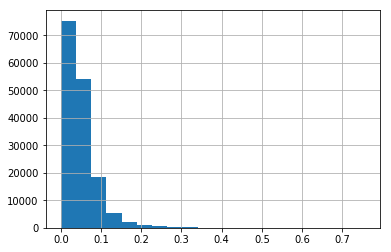

In [112]:
y['Zsep_inner'].hist(bins=20)

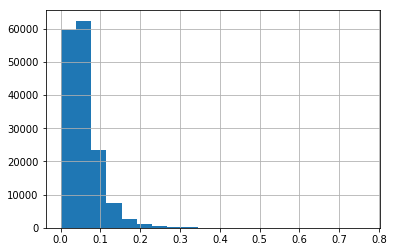

In [113]:
y['Zsep_outer'].hist(bins=20)

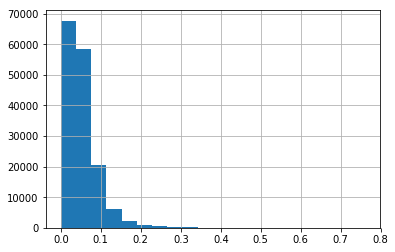

In [114]:
y['Zstarunstable'].hist(bins=20)

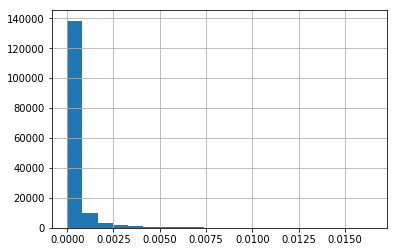

In [115]:
y['Zstarnonres'].hist(bins=20)

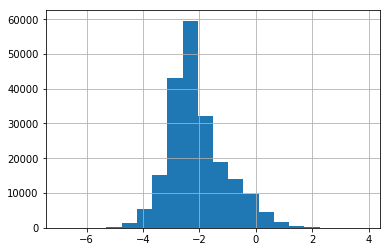

In [116]:
np.log10(y['res_strength']).hist(bins=20)